In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
#import geopandas as gpd
import seaborn as sns
import numpy as np
import yaml, random, os
from sklearn.model_selection import train_test_split, GroupShuffleSplit, ShuffleSplit
from sklearn.preprocessing import StandardScaler, QuantileTransformer

import torch, sys, logging
from torch import nn
import torch.nn.functional as F
from torch.utils.data.dataset import TensorDataset, Dataset
from torch.utils.data.dataloader import DataLoader
from torch.nn import init

from collections import defaultdict
import tqdm, joblib

from sklearn import datasets, linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from fmcml.data import load_data, load_splitter
from fmcml.model import DNN
import xgboost as xgb
import shap

In [2]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    #if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    #torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True

### Obtain CUDA device ID(s)

In [3]:
is_cuda = torch.cuda.is_available()
device = torch.device(torch.cuda.current_device()) if is_cuda else torch.device("cpu")

### Load the configuration

In [4]:
config = "../results/mlp_v7_2250m_site/best.yml"

In [5]:
with open(config) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

In [6]:
seed = conf["seed"]
seed_everything(seed)

save_loc = conf["save_loc"]
data_loc = conf["data_loc"]
total_input_vars = []
if conf["use_nwm"]:
    total_input_vars += conf["nwm_vars"]
if conf["use_sat"]:
    total_input_vars += conf["sat_vars"]
if conf["use_static"]:
    total_input_vars += conf["static_vars"]
if conf["use_hrrr"]:
    total_input_vars += conf["hrrr_vars"]
static_vars = conf["static_vars"]
output_vars = conf["output_vars"]
verbose = conf["verbose"]
splitter = conf["split_type"]

# model config
input_size = len(total_input_vars)
middle_size = conf["model"]["middle_size"] 
output_size = len(output_vars)
dropout = conf["model"]["dropout"]
num_layers = conf["model"]["num_layers"]
#optimzer config
learning_rate = conf["optimizer"]["learning_rate"]
L2_penalty = conf["optimizer"]["L2_penalty"]
# trainer config
n_splits = conf["trainer"]["n_splits"]
batch_size = conf["trainer"]["batch_size"]
valid_batch_size = conf["trainer"]["valid_batch_size"]
lr_patience = conf["trainer"]["lr_patience"]
stopping_patience = conf["trainer"]["stopping_patience"]
epochs = conf["trainer"]["epochs"]
batches_per_epoch = conf["trainer"]["batches_per_epoch"]
training_loss = conf["trainer"]["training_loss"]
metric = conf["trainer"]["metric"]
verbose = conf["verbose"]

### Load the dataset

In [7]:
df = load_data(
    data_loc,
    verbose = verbose,
    filter_input_vars = total_input_vars, 
    filter_output_vars = output_vars
)

In [8]:
data_folds = load_splitter(
    splitter,
    df, 
    n_splits = n_splits, 
    seed = seed,
    verbose = verbose
)

In [9]:
for k_fold, (train_data, valid_data, test_data) in enumerate(data_folds):
    scaler_x = QuantileTransformer(n_quantiles=1000, random_state=seed, output_distribution = "normal") #StandardScaler()
    scaler_y = QuantileTransformer(n_quantiles=1000, random_state=seed, output_distribution = "normal") #StandardScaler()
    x_train = scaler_x.fit_transform(train_data[total_input_vars])
    x_valid = scaler_x.transform(valid_data[total_input_vars])
    x_test  = scaler_x.transform(test_data[total_input_vars])
    y_train = scaler_y.fit_transform(train_data[output_vars])
    y_valid = scaler_y.transform(valid_data[output_vars])
    y_test  = scaler_y.transform(test_data[output_vars])
    break

### Neural network model 

In [11]:
test_split = TensorDataset(
    torch.from_numpy(x_test).float(),
    torch.from_numpy(y_test).float()
)
test_loader = DataLoader(test_split, 
                          batch_size=valid_batch_size, 
                          shuffle=False, 
                          num_workers=0)

In [12]:
def get_device():
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    return device


class DNN(torch.nn.Module):
    
    def __init__(self, inputSize, outputSize, block_sizes = [1000], dr = [0.5]):
        super(DNN, self).__init__()
        
        if len(block_sizes) > 0:
            blocks = self.block(inputSize, block_sizes[0], dr[0])
            if len(block_sizes) > 1:
                for i in range(len(block_sizes)-1):
                    blocks += self.block(block_sizes[i], block_sizes[i+1], dr[i])
            blocks.append(torch.nn.Linear(block_sizes[-1], outputSize))
        else:
            blocks = [torch.nn.Linear(inputSize, outputSize)]
        
        self.fcn = torch.nn.Sequential(*blocks)
        
    def block(self, inputSize, outputSize, dr):
        return [
            torch.nn.Linear(inputSize, outputSize),
            torch.nn.BatchNorm1d(outputSize),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(dr)
        ]

    def forward(self, x):
        x = self.fcn(x)
        return x
    
    def predict(self, x, batch_size = 10 * 1024):
        
        if len(x.shape) != 2:
            print(
                f"The input size should be (batch_size, input size), but recieved {x.shape}"
            )
            raise
            
        device = get_device()
        #logger.info(f"Mounting the model to device {device}")
        self.to(device) 
        self.eval()
        
        with torch.no_grad():
            if batch_size > x.shape[0]:
                X = np.array_split(x, x.shape[0] / batch_size)
                pred = torch.cat([
                    self.forward(torch.from_numpy(_x).float().to(device))
                    for _x in X
                ]).cpu()
            else:
                pred = self.forward(
                    torch.from_numpy(x).float().to(device)
                ).cpu()
                
        return pred.numpy()

In [13]:
model = DNN(
    input_size, 
    output_size, 
    block_sizes = [middle_size for k in range(num_layers)],
    dr = [dropout for k in range(num_layers)]
).to(device)

checkpoint = torch.load(
    f"{save_loc}/mlp.pt",
    map_location=lambda storage, loc: storage
)
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

### Feature importance

In [128]:
import numpy as np
import pandas as pd
import keras.backend as K

def variable_importance(data, labels, variable_names, model_name, model, score_func, permutations=30,
                        sklearn_model=False,
                        mean_model=False):
    if sklearn_model:
        preds = model.predict_proba(data)[:, 1]
    else:
        preds = model.predict(data)[:, 0]
    score = score_func(labels, preds)
    indices = np.arange(preds.shape[0])
    perm_data = np.copy(data)
    var_scores = pd.DataFrame(index=np.arange(permutations + 1), columns=variable_names, dtype=float)
    var_scores.loc[0, :] = score
    data_shape_len = len(data.shape)
    print(data.shape)
    for v, variable in tqdm.tqdm(enumerate(variable_names)):
        for p in range(1, permutations + 1):
            np.random.shuffle(indices)
            if mean_model and data_shape_len == 2:
                perm_data[:, v] = data[indices, v]
            elif mean_model and data_shape_len == 3:
                perm_data[:, :, v] = data[indices, :, v]
            else:
                perm_data[:, :, :, v] = data[indices, :, :, v]
            if sklearn_model:
                perm_preds = model.predict_proba(perm_data)[:, 1]
            else:
                perm_preds = model.predict(perm_data)[:, 0]
            var_scores.loc[p, variable] = score_func(labels, perm_preds)
        if mean_model:
            perm_data[:, v] = data[:, v]
        elif mean_model and data_shape_len == 3:
            perm_data[:, :, v] = data[:, :, v]
        else:
            perm_data[:, :, :, v] = data[:, :, :, v]
        score_diff = (var_scores.loc[0, variable] - var_scores.loc[1:, variable]) /  var_scores.loc[0, variable]
        print(model_name, variable, score_diff.mean(), score_diff.std())
    return var_scores


def variable_importance_faster(data, labels, variable_names, model_name, model, score_funcs, permutations=30,
                        sklearn_model=False,
                        mean_model=False):
    if sklearn_model:
        preds = model.predict_proba(data)[:, 1]
    else:
        preds = model.predict(data)[:, 0]
    scores = [sf(labels, preds) for sf in score_funcs]
    indices = np.arange(preds.shape[0])
    perm_data = np.copy(data)
    var_scores = []
    for s in range(len(score_funcs)):
        var_scores.append(pd.DataFrame(index=np.arange(permutations + 1), columns=variable_names, dtype=float))
        var_scores[-1].loc[0, :] = scores[s]
    data_shape_len = len(data.shape)
    for p in tqdm.tqdm(range(1, permutations + 1)):
        np.random.shuffle(indices)
        for v, variable in enumerate(variable_names):
            if mean_model and data_shape_len == 2:
                perm_data[:, v] = data[indices, v]
            elif mean_model and data_shape_len == 3:
                perm_data[:, :, v] = data[indices, :, v]
            else:
                perm_data[:, :, :, v] = data[indices, :, :, v]
            if sklearn_model:
                perm_preds = model.predict_proba(perm_data)[:, 1]
            else:
                perm_preds = model.predict(perm_data)[:, 0]
            for s, score_func in enumerate(score_funcs):
                var_scores[s].loc[p, variable] = score_func(labels, perm_preds)
            if mean_model:
                perm_data[:, v] = data[:, v]
            elif mean_model and data_shape_len == 3:
                perm_data[:, :, v] = data[:, :, v]
            else:
                perm_data[:, :, :, v] = data[:, :, :, v]
            #print(model_name, variable)
    return var_scores

In [ ]:
# var_scores = variable_importance_faster(
#     x_test, 
#     y_test, 
#     total_input_vars, 
#     "mlp",
#     model, 
#     [mean_squared_error], 
#     permutations=10,
#     sklearn_model=False,
#     mean_model=True)

In [ ]:
# order = var_scores[0].columns[np.argsort(np.mean(np.abs(var_scores[0]), axis=0))]
# var_scores = var_scores[0][order]
# var_mean = var_scores.mean(axis = 0).sort_values(ascending=False)
# var_std = var_scores.std(axis = 0).sort_values(ascending=False)

In [ ]:
# var_mean.plot.bar(yerr = var_std, figsize = (10, 5))
# plt.ylabel('importance')

In [17]:
def permut_features_importance(
    model, X, y, 
    loss_fun, n_repeats=10,
    columns_name=None
):
    
    X = np.asarray(X)
    assert X.ndim == 2
    
    y = np.asarray(y)
    assert y.ndim < 2
    
    if columns_name is not None:
        assert len(columns_name) == X.shape[-1]
    else:
        columns_name = np.arange(X.shape[-1])
    
    yp = model.predict(X)
    error = loss_fun(yp, y)
    features_imp = {}
    std_features_imp = {}     
        
    for col in tqdm.tqdm(range(X.shape[-1])):
        _importance = []
        for _ in range(n_repeats):
            _X = np.copy(X)
            _X[:,col] = np.random.permutation(_X[:,col])
            yp = model.predict(_X)
            _importance.append(loss_fun(yp, y) - error)
                
        features_imp[columns_name[col]] = np.mean(_importance)
        std_features_imp[columns_name[col]] = np.std(_importance)
                
    return features_imp, std_features_imp

In [22]:
feat_imp_diz = permut_features_importance(
    model, x_test, y_test.squeeze(-1), 
    loss_fun=mean_squared_error, 
    n_repeats=30, 
    columns_name=total_input_vars)

feat_imp_mean, feat_imp_std = feat_imp_diz
feat_imp_mean = pd.Series(feat_imp_mean)
feat_imp_std = pd.Series(feat_imp_std)

order = feat_imp_mean.sort_values(ascending=False).index
feat_imp_mean = feat_imp_mean[order]
feat_imp_std = feat_imp_std[order]

100%|██████████| 38/38 [27:45<00:00, 43.83s/it]


Text(0, 0.5, 'importance')

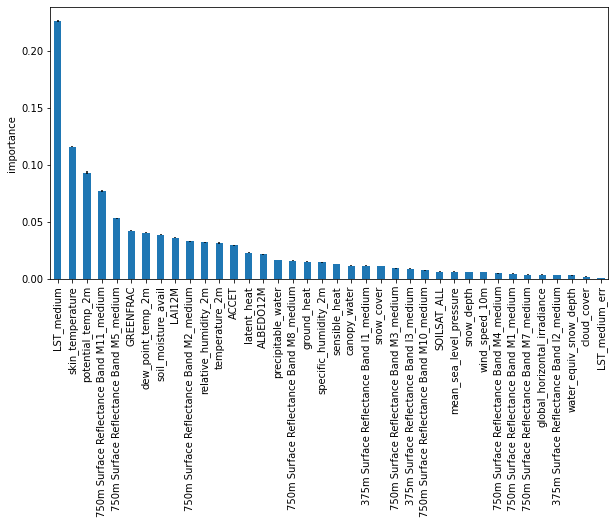

In [23]:
feat_imp_mean.plot.bar(yerr=feat_imp_std, figsize = (10, 5))
plt.ylabel('importance')

### Use Captum for the pytorch model

In [24]:
from captum import attr
import gc

In [26]:
batch_size = 128

ig_attr_test = []
ig_nt_attr_test = []
dl_attr_test = []
gs_attr_test = []
fa_attr_test = []

ig = attr.IntegratedGradients(model)
ig_nt = attr.NoiseTunnel(ig)
dl = attr.DeepLift(model)
gs = attr.GradientShap(model)
fa = attr.FeatureAblation(model)

indices = list(range(x_test.shape[0]))
for k in tqdm.tqdm(range(len(indices) // batch_size)):
    #random.shuffle(indices)
    #_x = torch.from_numpy(x_test[indices[:batch_size]]).to(device)
    _x = torch.from_numpy(x_test[k * batch_size: (k + 1) * batch_size]).to(device)

    ig_attr_test.append(ig.attribute(_x, n_steps=50).cpu())
    ig_nt_attr_test.append(ig_nt.attribute(_x).cpu())
    gc.collect()

    dl_attr_test.append(dl.attribute(_x).cpu())
    gc.collect()

    _x_comp = torch.from_numpy(x_train).to(device)
    gs_attr_test.append(gs.attribute(_x, _x_comp).cpu())
    del _x_comp
    gc.collect()

    fa_attr_test.append(fa.attribute(_x).cpu())
    gc.collect()
    
#     if k == 50:
#         break

In [27]:
ig_attr_test = torch.vstack(ig_attr_test)[:, perm_order]
ig_nt_attr_test = torch.vstack(ig_nt_attr_test)[:, perm_order]
dl_attr_test = torch.vstack(dl_attr_test)[:, perm_order]
gs_attr_test = torch.vstack(gs_attr_test)[:, perm_order]
fa_attr_test = torch.vstack(fa_attr_test)[:, perm_order]

In [131]:
# prepare attributions for visualization

#x_axis_data = np.arange(_x.shape[1]) #[total_input_vars.index(col) for col in order] 
#x_axis_data_labels = list(map(lambda idx: total_input_vars[idx], perm_order))

ig_attr_test_sum = ig_attr_test.detach().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

ig_nt_attr_test_sum = ig_nt_attr_test.detach().numpy().sum(0)
ig_nt_attr_test_norm_sum = ig_nt_attr_test_sum / np.linalg.norm(ig_nt_attr_test_sum, ord=1)

dl_attr_test_sum = dl_attr_test.detach().numpy().sum(0)
dl_attr_test_norm_sum = dl_attr_test_sum / np.linalg.norm(dl_attr_test_sum, ord=1)

gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)

lin_weight = model.fcn[0].weight[0].detach().cpu().numpy()
y_axis_lin_weight = lin_weight / np.linalg.norm(lin_weight, ord=1)

In [149]:
importance_results = pd.DataFrame.from_dict({
    "permutation": feat_imp_mean / feat_imp_mean.sum(),
    "integrated_gradients": ig_attr_test_norm_sum,
    "noise_tunnel": ig_nt_attr_test_norm_sum,
    "deep_lift": dl_attr_test_norm_sum,
    "gradient_shap": gs_attr_test_norm_sum,
    "feature_ablation": fa_attr_test_norm_sum,
    "layer1_weights": y_axis_lin_weight
})

In [150]:
new_order = importance_results.abs().mean(axis=1).sort_values(ascending=False).index
importance_results = importance_results.reindex(new_order)

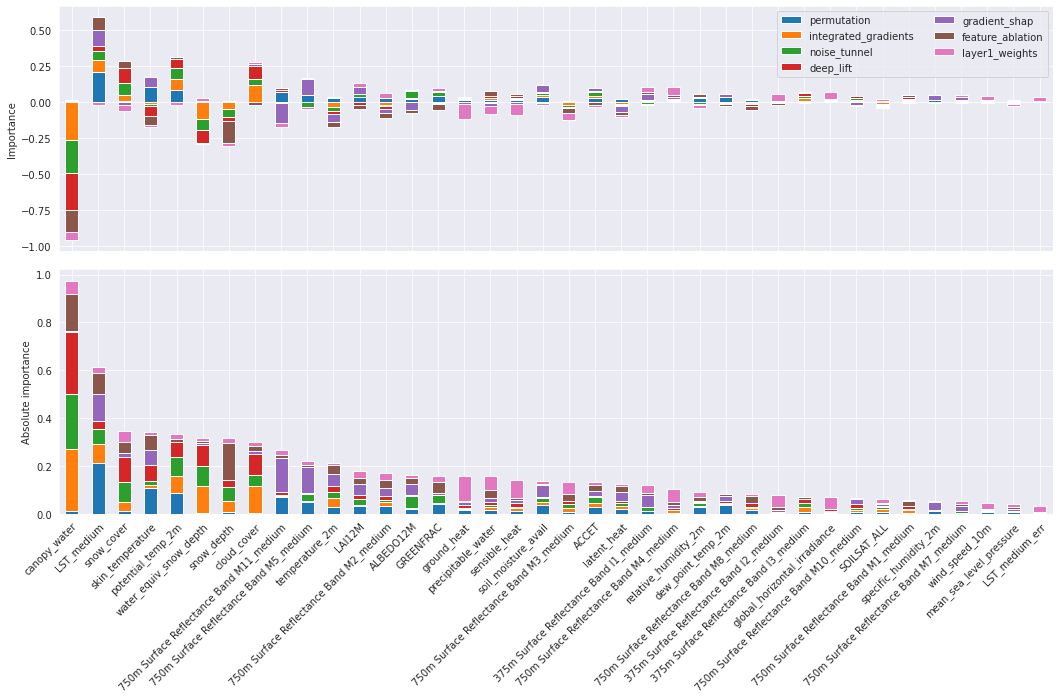

In [156]:
sns.set_style("dark")
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (15, 10), sharex = True, sharey = "row")

ax1 = importance_results.plot(kind="bar", ax = ax1, stacked=True, legend = False, fontsize = 10)
ax1.grid()

ax2 = importance_results.abs().plot(kind="bar", ax = ax2, stacked=True, legend = False, fontsize = 10)
ax2.set_xticks(range(importance_results.shape[0]))
_ = ax2.set_xticklabels(importance_results.index, rotation=45, rotation_mode="anchor", ha = "right", fontsize = 10)
ax2.grid()

ax1.legend(importance_results.columns, ncol = 2, fontsize = 10, loc = "best")
ax1.set_ylabel("Importance", fontsize = 10)
ax2.set_ylabel("Absolute importance", fontsize = 10)
plt.tight_layout()

### XGB model

In [10]:
config = "../results/xgb_v7_2250m_site/best.yml"

In [11]:
with open(config) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)
    
n_splits = conf["model"]["n_splits"]
objective = conf["model"]["objective"]
learning_rate = conf["model"]["learning_rate"]
n_estimators = conf["model"]["n_estimators"]
max_depth = conf["model"]["max_depth"]
n_jobs = conf["model"]["n_jobs"]
colsample_bytree = conf["model"]["colsample_bytree"]
gamma = conf["model"]["gamma"]
learning_rate = conf["model"]["learning_rate"]
max_depth = conf["model"]["max_depth"]
subsample = conf["model"]["subsample"]
metric = conf["model"]["metric"]

In [12]:
with open(os.path.join(conf["save_loc"], "model_results.pkl"), "rb") as fid:
    xgb_model, results = joblib.load(fid)

##### Gain

In [13]:
feature_importance = xgb_model.get_booster().get_score(importance_type='gain')
sorted_features = sorted([x for x in feature_importance.items()], key = lambda x: x[1], reverse = True)

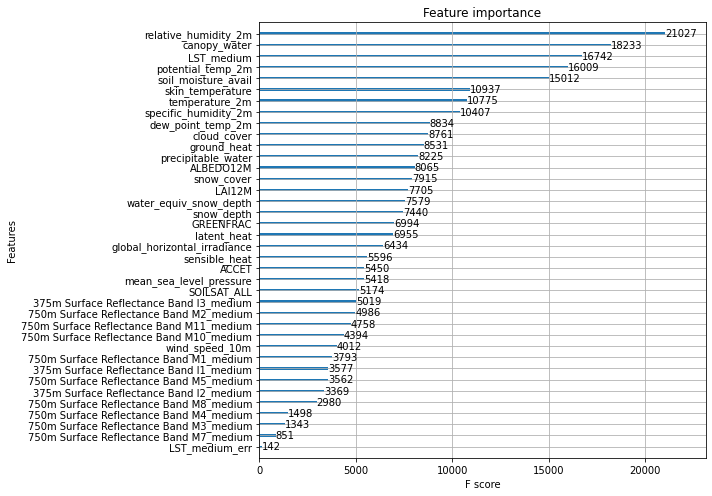

In [14]:
fig, ax = plt.subplots(figsize=(10, 7))
feature_plot = xgb.plot_importance(xgb_model, ax=ax)
ylabels = [total_input_vars[int(x[0].strip("f"))] for x in sorted_features][::-1]
_ = ax.set_yticklabels(ylabels, fontsize = 9)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title("Feature importance", fontsize=12)
plt.xlabel("F score", fontsize=10)
plt.ylabel("Features", fontsize=10)
plt.tight_layout()

In [15]:
gain_importance = pd.DataFrame.from_dict({
    "variable": ylabels[::-1],
    "gain": [_[1] for _ in sorted_features]
})

##### Permutation

In [18]:
xgb_feat_imp_diz = permut_features_importance(
    xgb_model, x_test, y_test.squeeze(-1), 
    loss_fun=mean_squared_error, 
    n_repeats=30, 
    columns_name=total_input_vars)

xgb_feat_imp_mean, xgb_feat_imp_std = xgb_feat_imp_diz
xgb_feat_imp_mean = pd.Series(xgb_feat_imp_mean)
xgb_feat_imp_std = pd.Series(xgb_feat_imp_std)

order = xgb_feat_imp_mean.sort_values(ascending=False).index
xgb_feat_imp_mean = xgb_feat_imp_mean[order]
xgb_feat_imp_std = xgb_feat_imp_std[order]

100%|██████████| 38/38 [09:33<00:00, 15.10s/it]


In [19]:
perm_importance = pd.DataFrame.from_dict({
    "variable": xgb_feat_imp_mean.index,
    "permutation": xgb_feat_imp_mean
})

Text(0, 0.5, 'importance')

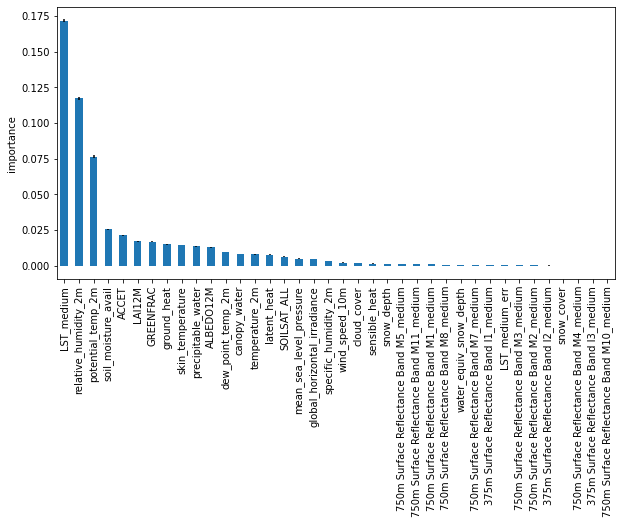

In [20]:
xgb_feat_imp_mean.plot.bar(yerr=xgb_feat_imp_std, figsize = (10, 5))
plt.ylabel('importance')

##### SHAP

In [21]:
explainer = shap.TreeExplainer(xgb_model, x_train)

In [22]:
xgb_shap_values = explainer.shap_values(x_test)

100%|===================| 95332/95344 [111:52<00:00]        

In [23]:
xgb_shap_mean = pd.Series(np.abs(xgb_shap_values).mean(axis=0))
xgb_shap_std = pd.Series(np.abs(xgb_shap_values).std(axis=0))

order = xgb_shap_mean.sort_values(ascending=False).index
xgb_shap_mean = xgb_shap_mean[order]
xgb_shap_std = xgb_shap_std[order]
xgb_shap_mean.index = [total_input_vars[i] for i in xgb_shap_mean.index]

In [24]:
shap_importance = pd.DataFrame.from_dict({
    "variable": xgb_shap_mean.index,
    "shap": xgb_shap_mean
})

Text(0, 0.5, 'importance')

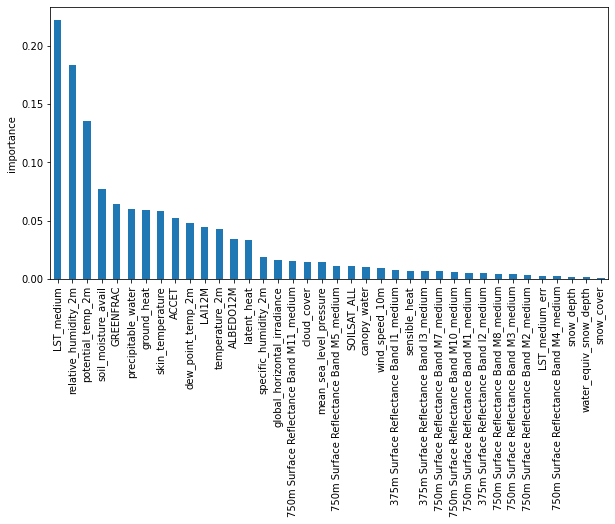

In [25]:
ax = xgb_shap_mean.plot.bar(yerr=xgb_shap_std, figsize = (10, 5))
ax.set_ylabel('importance')

### Combined figure

In [26]:
import functools as ft
dfs = [gain_importance, perm_importance, shap_importance]
xgb_importance = ft.reduce(lambda left, right: pd.merge(left, right, on='variable'), dfs) 

In [27]:
metrics = ["gain", "permutation", "shap"]
xgb_importance["gain"] /= xgb_importance["gain"].sum()
xgb_importance["permutation"] /= xgb_importance["permutation"].sum()
xgb_importance["shap"] /= xgb_importance["shap"].sum()

In [28]:
xgb_new_order = xgb_importance[metrics].abs().mean(axis=1).sort_values(ascending=False).index
xgb_importance = xgb_importance.reindex(xgb_new_order)

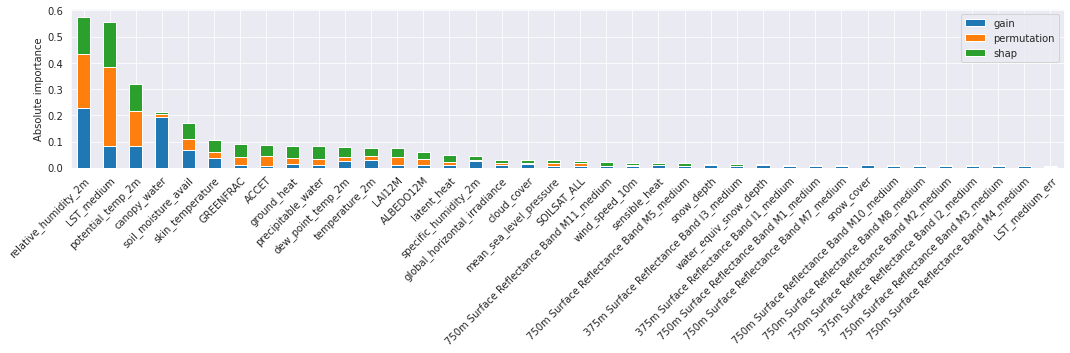

In [29]:
sns.set_style("dark")
fig, ax1 = plt.subplots(nrows = 1, ncols = 1, figsize = (15, 5), sharex = True, sharey = "row")

ax1 = xgb_importance[metrics].abs().plot(kind="bar", ax = ax1, stacked=True, legend = False, fontsize = 10)
ax1.set_xticks(range(xgb_importance.shape[0]))
_ = ax1.set_xticklabels(xgb_importance["variable"], rotation=45, rotation_mode="anchor", ha = "right", fontsize = 10)
ax1.grid()

ax1.legend(metrics, ncol = 1, fontsize = 10, loc = "best")
ax1.set_ylabel("Absolute importance", fontsize = 10)
plt.tight_layout()